## Tutorial Overview: Text Analysis Pipeline

In this tutorial, we'll demonstrate the power of LangGraph by building a multi-step text analysis pipeline. Our use case will focus on processing a given text through three key stages:

1. **Text Classification**: We'll categorize the input text into predefined categories (e.g., News, Blog, Research, or Other).
2. **Entity Extraction**: We'll identify and extract key entities such as persons, organizations, and locations from the text.
3. **Text Summarization**: Finally, we'll generate a concise summary of the input text.

In [1]:
%%capture
!pip install langchain langchain_core langchain_community langgraph langchain_groq

In [2]:
from typing import TypedDict,List
from langgraph.graph import StateGraph, END
from langchain.prompts import PromptTemplate
from langchain.schema import HumanMessage
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image

In [7]:
from langchain_groq import ChatGroq
from google.colab import userdata
llm = ChatGroq(
    temperature=0,
    groq_api_key = userdata.get('gro_api'),
    model_name = "llama-3.3-70b-versatile"
)


Building the text preprocessing pipeline
1. Define State & Initialize LLM
2. Define Node Function
3. Create Tools & Build Workflow
4. Visualize the Workflow
5. Testing the Pipeline

##1. Define State & Initialize LLM

In [3]:
class State(TypedDict):
  text: str
  classification: str
  entities: List[str]
  summary: str

##2. Define Node Function

In [8]:
def classification_node(state: State):
  "Research, News, Blog or Others"
  prompt = PromptTemplate(
      input_variable = ["text"],
      template = "Classify the following text into one of the categories: News, Blog, Research , or Other. \n\nText:{text}\n\nCategory:"
  )
  message = HumanMessage(content = prompt.format(text = state["text"]))
  classification = llm.invoke([message]).content.strip()
  return {"classification":classification}

def entity_extraction_node(state: State):
  prompt = PromptTemplate(
      input_variables=["text"],
      template = "Extract all the entities (Person, Organization, Location) from the following text. Provide the result as a comma separated list. \n\nText:{text}\n\nEntities:"
  )
  message = HumanMessage(content = prompt.format(text = state["text"]))
  entities = llm.invoke([message]).content.strip().split(", ")
  return {"entities": entities}

def summarization_node(state: State):
  prompt = PromptTemplate(
      input_variable = ["text"],
      template = "Summarize the following text in one short sentence. \n\nText:{text}\n\Summary:"
  )
  message = HumanMessage(content = prompt.format(text = state["text"]))
  summary = llm.invoke([message]).content.strip()
  return {"summary":summary}


##3. Create Tools & Build Workflow

In [9]:
workflow = StateGraph(State)

workflow.add_node("classification_node", classification_node)
workflow.add_node("entity_extraction_node", entity_extraction_node)
workflow.add_node("summarization_node", summarization_node)

workflow.set_entry_point("classification_node")

workflow.add_edge("classification_node", "entity_extraction_node")
workflow.add_edge("entity_extraction_node", "summarization_node")
workflow.add_edge("summarization_node", END)

app = workflow.compile()

##4.Visualize the Workflow

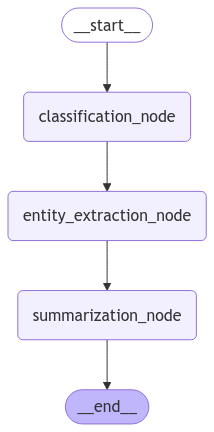

In [10]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

##5. Testing the Pipeline

In [11]:
SAMPLE_TEXT = """OpenAI has announced the GPT-4 model, which is a large multimodal model that exhibits human-level performance on various professional benchmarks. It is developed to improve the alignment and safety of AI systems.
additionally, the model is designed to be more efficient and scalable than its predecessor, GPT-3. The GPT-4 model is expected to be released in the coming months and will be available to the public for research and development purposes."""

state_input = {"text": SAMPLE_TEXT}
result = app.invoke(state_input)

In [12]:
print("Classification :", result["classification"])
print("\nEntities :", result["entities"])
print("\nSummary :", result["summary"])

Classification : Category: News

The text appears to be a factual report about a recent development in the field of AI, specifically the announcement of the GPT-4 model by OpenAI. The language used is formal and objective, and the text provides information about the model's features and expected release date, which is typical of news articles.

Entities : ['OpenAI', 'GPT-4', 'GPT-3']

Summary : OpenAI has announced the GPT-4 model, a large multimodal model that exhibits human-level performance and is designed to be more efficient and safer than its predecessor.


In [13]:
# Homework
# Gradio Application

In [14]:
sample_text_research = """
Recent advancements in quantum computing have shown potential in solving problems related to cryptography and optimization. Researchers from MIT and IBM have published findings that demonstrate a quantum processor's capability to outperform classical algorithms in specific tasks. This breakthrough could lead to significant advancements in secure communications and computational biology.
"""

state_input_research = {"text": sample_text_research}
result_research = app.invoke(state_input_research)

print("Classification:", result_research["classification"])
print("\nEntities:", result_research["entities"])
print("\nSummary:", result_research["summary"])


Classification: Category: Research

Entities: ['MIT', 'IBM', '\n\n(Note: There are no person entities mentioned in the text. The locations mentioned', 'MIT and IBM', 'can also be considered as organizations. If you want to consider them as locations as well', 'you can add them to the location category', 'but in this context', 'they seem to be referred to as organizations.)']

Summary: Recent advancements in quantum computing have shown potential to outperform classical algorithms in certain tasks, leading to potential breakthroughs in secure communications and computational biology.


In [ ]:
sample_text_blog = """
In a world where technology is evolving rapidly, AI has become a buzzword that's reshaping industries. From personalized shopping recommendations to self-driving cars, artificial intelligence is touching our lives in incredible ways. In this blog, we explore the top five AI trends that are set to revolutionize 2024.
"""

state_input_blog = {"text": sample_text_blog}
result_blog = app.invoke(state_input_blog)

print("Classification:", result_blog["classification"])
print("\nEntities:", result_blog["entities"])
print("\nSummary:", result_blog["summary"])


Classification: Category: Blog

Entities: ['Since there are no explicit mentions of Person', 'Organization', 'or Location in the given text', 'the result is an empty list. \n\nEntities:']

Summary: This blog explores the top five AI trends expected to revolutionize 2024.
